# Analysis of Individual Effects on the BUSI Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.multitest import multipletests
from tbparse import SummaryReader

LOG_DIR = "../tensorboard_logs/individual_effects/busi"

TRANSFORM_TO_LABEL = {
    "elastic_transform": "Elastic",
    "center_crop": "None",
    "saturation": "Saturation",
    "equalize": "Equalize",
    "vertical_flip": "Flip V.",
    "gaussian_blur": "Gauss. blur",
    "shear_x": "Shear X",
    "horizontal_flip": "Flip H.",
    "contrast": "Contrast",
    "brightness": "Brightness",
    "median_blur": "Median blur",
    "grid_distortion": "Grid distort",
    "random_crop": "Random crop",
    "translate_x": "Translate X",
    "translate_y": "Translate Y",
    "scaling": "Scale",
    "gaussian_noise": "Gauss. noise",
    "rotation": "Rotate",
    "shear_y": "Shear Y",
}

## Load Tensorboard Logs

In [2]:
reader = SummaryReader(LOG_DIR, extra_columns={"wall_time", "dir_name"})

df = reader.scalars
df["wall_time"] = pd.to_datetime(df["wall_time"], unit="s")
df[["transform", "split", "train_fold", "log_dir", "run"]] = df["dir_name"].str.split(
    pat="/", n=4, expand=True
)
df["train_fold"] = df["train_fold"].str.replace("trainfold_", "").astype(int)
df["split"] = df["split"].str.replace("split_", "").astype(int)
df["run"] = df["run"].str.replace("version_", "").astype(int)
df = df.drop(columns=["log_dir"])
df.head()

,step,tag,value,wall_time,dir_name,transform,split,train_fold,run
0,4,epoch,0.0,2024-03-04 23:56:46.265971422,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
1,5,epoch,0.0,2024-03-04 23:56:48.010061502,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
2,5,epoch,0.0,2024-03-04 23:56:48.520948887,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
3,9,epoch,1.0,2024-03-04 23:56:50.283200264,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134
4,11,epoch,1.0,2024-03-04 23:56:52.042407990,brightness/split_0/trainfold_0/lightning_logs/...,brightness,0,0,45295134


## Calculate Performance Differences

1. Calculate the change in balanced validation accuracy for each run compared to using no augmentation (i.e., center crop) for the same `split` and `train_fold`.
2. Perform one-sided t-tests with Holm-Bonferroni correction to determine if the change in balanced validation accuracy is statistically significant.
3. Calculate the mean balanced validation and mean difference of the 5 measurements from 5 x 2 cross validation for each augmentation.

In [3]:
results_df = (
    df[df["tag"] == "val/bacc_epoch"][
        ["transform", "train_fold", "split", "run", "value"]
    ]
    .groupby(["transform", "train_fold", "split", "run"])
    .max("value")
    .reset_index()
)
baseline_df = results_df[results_df["transform"] == "center_crop"]

results_df = pd.merge(results_df, baseline_df, on=["train_fold", "split"])
results_df = results_df.rename(
    columns={"value_x": "bacc", "value_y": "bacc_baseline", "transform_x": "transform"}
)
results_df["diff"] = results_df["bacc"] - results_df["bacc_baseline"]
results_df = results_df.drop(columns=["run_x", "transform_y", "run_y"])
results_df.head()

,transform,train_fold,split,bacc,bacc_baseline,diff
0,brightness,0,0,0.809378,0.771873,0.037504
1,brightness,0,1,0.800314,0.759803,0.040511
2,brightness,0,2,0.813552,0.777515,0.036038
3,brightness,0,3,0.796041,0.781858,0.014183
4,brightness,0,4,0.827965,0.817757,0.010208


In [4]:
def perform_ttest(df, op):
    """Implements the 5 x 2 CV paired t test proposed by Dieterrich (1998) to compare the
    performance of two learning algorithms.

    Modified from MLxtend: https://github.com/rasbt/mlxtend/blob/b3b81f4dd603e0ad9c8f3133f1b2bf2f5177cc9d/mlxtend/evaluate/ttest.py#L237
    """
    first_diff = None
    variance_sum = 0.0
    for split in range(5):
        diff_fold0 = df[
            (df["transform"] == op) & (df["train_fold"] == 0) & (df["split"] == split)
        ]["diff"].iloc[0]
        diff_fold1 = df[
            (df["transform"] == op) & (df["train_fold"] == 1) & (df["split"] == split)
        ]["diff"].iloc[0]

        diff_mean = (diff_fold0 + diff_fold1) / 2.0
        diff_var = (diff_fold0 - diff_mean) ** 2 + (diff_fold1 - diff_mean) ** 2

        variance_sum += diff_var
        if first_diff is None:
            first_diff = diff_fold0

    numerator = first_diff
    denominator = np.sqrt(1 / 5.0 * variance_sum)
    t_stat = numerator / denominator

    p_value = stats.t.sf(t_stat, 5)

    return op, t_stat, p_value


# Calculate p values
p_values = [
    perform_ttest(results_df, x)
    for x in results_df[results_df["transform"] != "center_crop"]["transform"].unique()
]
p_values = pd.DataFrame(p_values, columns=["transform", "t_stat", "p_value"])

# Perform multiple testing correction
reject, p_values_adj, _, _ = multipletests(p_values["p_value"], method="holm")
p_values["p_value_adj"] = p_values_adj
p_values["reject"] = reject

p_values.head(20)

,transform,t_stat,p_value,p_value_adj,reject
0,brightness,4.104241,0.004658,0.074529,False
1,contrast,3.562629,0.008085,0.121271,False
2,elastic_transform,-0.827220,0.777109,1.000000,False
3,equalize,0.479591,0.325880,1.000000,False
4,gaussian_blur,1.088562,0.163005,0.815027,False
5,gaussian_noise,1.903828,0.057648,0.345887,False
6,grid_distortion,2.330288,0.033594,0.236127,False
7,horizontal_flip,3.213550,0.011817,0.153627,False
8,median_blur,2.434782,0.029516,0.236127,False
9,random_crop,2.782898,0.019384,0.213229,False


In [5]:
# Calculate means
agg_results_df = (
    results_df.groupby(["transform", "split"])
    .mean()
    .reset_index()
    .drop(columns=["train_fold"])
)
agg_results_df = (
    agg_results_df.groupby("transform").mean().reset_index().drop(columns=["split"])
)
agg_results_df = pd.merge(
    agg_results_df, p_values, left_on="transform", right_on="transform", how="left"
)
agg_results_df.sort_values("diff").head(20)

,transform,bacc,bacc_baseline,diff,t_stat,p_value,p_value_adj,reject
3,elastic_transform,0.760923,0.789712,-0.028789,-0.827220,0.777109,1.000000,False
1,center_crop,0.789712,0.789712,0.000000,NaN,NaN,NaN,NaN
12,saturation,0.791001,0.789712,0.001289,0.182806,0.431066,1.000000,False
4,equalize,0.798629,0.789712,0.008917,0.479591,0.325880,1.000000,False
18,vertical_flip,0.803134,0.789712,0.013423,2.639145,0.023012,0.223710,False
9,median_blur,0.803371,0.789712,0.013659,2.434782,0.029516,0.236127,False
5,gaussian_blur,0.803737,0.789712,0.014025,1.088562,0.163005,0.815027,False
2,contrast,0.808844,0.789712,0.019132,3.562629,0.008085,0.121271,False
8,horizontal_flip,0.809972,0.789712,0.020260,3.213550,0.011817,0.153627,False
14,shear_x,0.814695,0.789712,0.024983,0.719435,0.252043,1.000000,False


## Save Results

In [6]:
agg_results_df.to_csv("../results/busi_individual_agg.csv", index=False)
results_df.to_csv("../results/busi_individual.csv", index=False)

## Plot Performance Differences

### Bar Plot

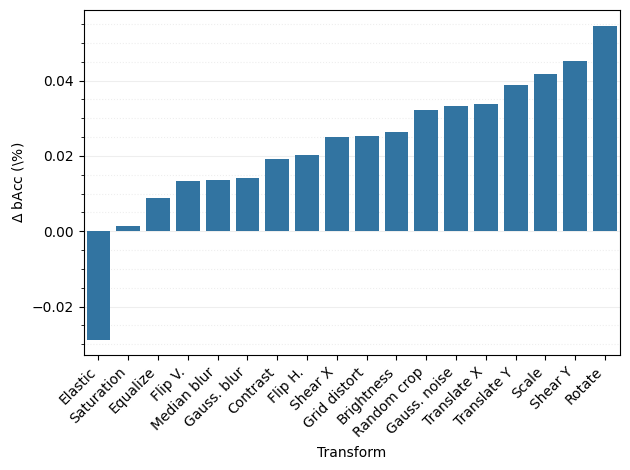

In [7]:
plot_df = agg_results_df[agg_results_df["transform"] != "center_crop"].sort_values(
    "diff"
)

ax = sns.barplot(plot_df, x="transform", y="diff")
ax.set_xlabel("Transform")
ax.set_ylabel("$\Delta$ bAcc (\%)")
ax.set_xticks(
    plot_df["transform"],
    labels=[TRANSFORM_TO_LABEL[x] for x in plot_df["transform"]],
    rotation=45,
    ha="right",
)

# Gridlines
ax.yaxis.set_minor_locator(MultipleLocator(0.005))
ax.yaxis.grid(True, which="major", color="#EEEEEE")
ax.yaxis.grid(True, which="minor", color="#EEEEEE", linestyle=":")
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("../results/busi_individual_bar.pdf", bbox_inches="tight")
plt.show()

### Violin Plot

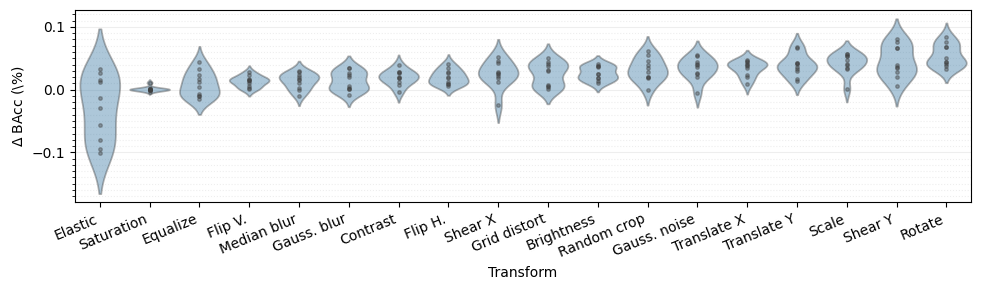

In [8]:
ordering = (
    agg_results_df[agg_results_df["transform"] != "center_crop"]
    .sort_values("diff")["transform"]
    .tolist()
)
plot_df = results_df[results_df["transform"] != "center_crop"].sort_values("diff")

fig = plt.figure(figsize=(10, 3))

C0 = [0.19460784, 0.45343137, 0.63284314, 1.0]
C1 = [0.88186275, 0.50539216, 0.17303922, 1.0]

# Draw violins
ax = sns.violinplot(
    plot_df,
    x="transform",
    y="diff",
    order=ordering,
    inner="point",
    density_norm="count",
)
for violin, alpha in zip(ax.collections, [0.4] * len(ax.collections)):
    violin.set_alpha(alpha)

# Gridlines
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.grid(True, which="major", color="#EEEEEE")
ax.yaxis.grid(True, which="minor", color="#EEEEEE", linestyle=":")
ax.set_axisbelow(True)

# Axes
ax.set_ylabel("$\Delta$ BAcc (\%)")
ax.set_xlabel("Transform")
ax.set_xticks(
    ordering,
    labels=[TRANSFORM_TO_LABEL[x] for x in ordering],
    rotation=22.5,
    ha="right",
)

plt.tight_layout()
plt.savefig("../results/busi_individual_violin.pdf", bbox_inches="tight")
plt.show()